In [2]:
import os
from metient.util import plotting_util as putil
from metient.util.globals import *

REPO_DIR = os.path.join(os.getcwd(), "../")

CUDA GPU: False


In [3]:
import glob
import gzip
import pickle
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd

DATASET_NAMES = ["Breast Cancer", "Melanoma", "HGSOC", "Neuroblastoma", "NSCLC"]
CALIBRATE_DIRS = [os.path.join(REPO_DIR,"data/hoadley_breast_cancer_2016/metient_outputs/calibrate"),
                  os.path.join(REPO_DIR,"data/sanborn_melanoma_2015/metient_outputs/calibrate"),
                  os.path.join(REPO_DIR,"data/mcpherson_ovarian_2016/metient_outputs/calibrate"),
                  os.path.join(REPO_DIR,"data/gundem_neuroblastoma_2023/metient_outputs/calibrate"),
                  os.path.join(REPO_DIR,"data/tracerx_nsclc/metient_outputs/pyclone_clustered_conipher_trees_01222024/calibrate")]

desired_order = ["primary single-source", "single-source", 'multi-source', "reseeding"]
data = []
for calibrate_dir,dataset in zip(CALIBRATE_DIRS, DATASET_NAMES):

    # Use glob to get the list of matching files
    matching_files = glob.glob(f'{calibrate_dir}/*pkl.gz')
    patients = [m.split("/")[-1].split("_")[0] for m in matching_files]
    print(dataset, len(patients))
    patterns = []
    for fn in matching_files:
        with gzip.open(fn, 'rb') as f:
            pkl = pickle.load(f)
            V = torch.tensor(pkl[OUT_LABElING_KEY][0])
            A = torch.tensor(pkl[OUT_ADJ_KEY][0])
            pattern = " ".join(putil.get_verbose_seeding_pattern(V,A).split(" ")[1:]).replace(" seeding", "")
            patterns.append(pattern)
            data.append([dataset, desired_order.index(pattern)])
    print(set(patterns))
    
    counts = Counter({p: 0 for p in desired_order})
    # Update counts with actual counts from data
    counts.update(patterns)
    print(counts)

df = pd.DataFrame(data, columns=['dataset', 'seeding pattern'])
df

Breast Cancer 2
{'primary single-source', 'single-source'}
Counter({'primary single-source': 1, 'single-source': 1, 'multi-source': 0, 'reseeding': 0})
Melanoma 8
{'primary single-source', 'reseeding', 'multi-source', 'single-source'}
Counter({'primary single-source': 5, 'single-source': 1, 'multi-source': 1, 'reseeding': 1})
HGSOC 7
{'primary single-source', 'reseeding', 'multi-source'}
Counter({'primary single-source': 4, 'multi-source': 2, 'reseeding': 1, 'single-source': 0})
Neuroblastoma 26
{'primary single-source', 'multi-source', 'single-source'}
Counter({'primary single-source': 15, 'single-source': 6, 'multi-source': 5, 'reseeding': 0})
NSCLC 128
{'primary single-source', 'multi-source', 'single-source'}
Counter({'primary single-source': 99, 'multi-source': 24, 'single-source': 5, 'reseeding': 0})


,dataset,seeding pattern
0,Breast Cancer,0
1,Breast Cancer,1
2,Melanoma,0
3,Melanoma,0
4,Melanoma,1
...,...,...
166,NSCLC,0
167,NSCLC,0
168,NSCLC,2
169,NSCLC,0


[(0.888292, 0.40830288, 0.36223756), (0.81942908, 0.28911553, 0.38102921), (0.69226314, 0.23413578, 0.42480327), (0.56041794, 0.19845221, 0.44207535), (0.42355299, 0.16934709, 0.42581586)]


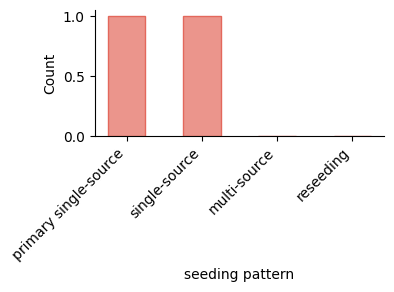

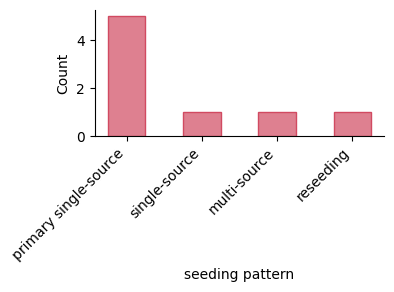

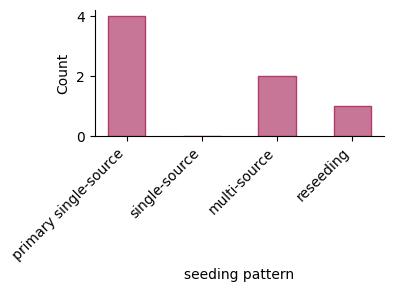

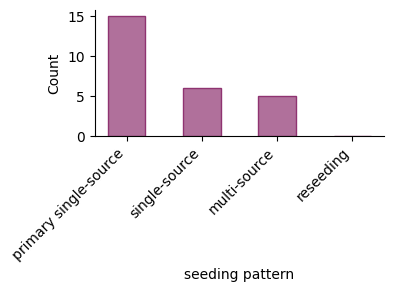

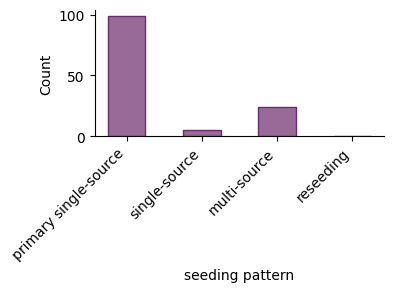

In [13]:
COLORS = sns.color_palette("flare")[1:]
print(COLORS)
for dataset,color in zip(DATASET_NAMES, COLORS):
    plt.figure(figsize=(4, 3))
    subset = df[df['dataset']==dataset]
    ax = sns.histplot(data=subset, bins=len(desired_order), alpha=0.7, color=color, edgecolor=color,
                      binrange=(0, len(desired_order)), x="seeding pattern", shrink=0.5)
    sns.despine(ax=ax, left=False, right=True, top=True, bottom=False)
    ax.set_xticks([0.5,1.5,2.5,3.5])
    ax.set_xticklabels(desired_order)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    plt.tight_layout(pad=1.0) 
    saved_name = "_".join(dataset.split(" "))
    plt.savefig(f"{saved_name}_seeding_pattern_distribution.png", dpi=300)
    plt.show()
    plt.close()